In [1]:
import numpy as np
def CBS(row):
    """consolidated bid size"""
    col = row.copy() * -1
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]

def CAS(row):
    """consolidated ask size"""
    col = row.copy()
    col[col <= 0] = 0
    diff = np.abs(np.diff(col))
    return np.sum(diff) + col[0]

def TCBS(cbs):
    """total consolidated bid size"""
    return np.sum(cbs)

def TCAS(cas):
    """total consolidated ask size"""
    return np.sum(cas)

def WBP(cbs):
    """weighted bid price"""
    tcbs = TCBS(cbs)
    wbp = 0
    for p, cbsi in enumerate(cbs):
        wbp += (p+1) * (cbsi / tcbs)
    return wbp

def WAP(cas):
    """weighted bid price"""
    tcas = TCAS(cas)
    wbp = 0
    for p, casi in enumerate(cas):
        wbp += (p+1) * (casi / tcas)
    return wbp

def AWS(row):
    """actvity weighted spread"""
    return WAP(row) - WBP(row)

def AP(tapes_segment):
    """average price"""
    pass

def AWR(tapes):
    """activity weighted return"""
    pass

In [2]:
from tools import read_csr
data = read_csr(0)

In [3]:
import pandas as pd
df = data[0]
df.index = pd.to_datetime(df.index)
df

C:\Users\wwden\AppData\Local\Temp\ipykernel_28412\426244162.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index)


,1,2,3,4,5,6,7,8,9,10,...,791,792,793,794,795,796,797,798,799,800
0,,,,,,,,,,,,,,,,,,,,,
2024-03-09 08:00:00.000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-03-09 08:00:00.279,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-03-09 08:00:01.333,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2024-03-09 08:00:01.581,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2024-03-09 08:00:01.643,-6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-09 16:29:59.542,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-03-09 16:29:59.573,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2024-03-09 16:29:59.635,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
min_df = pd.DataFrame()
arr = df.to_numpy()

min_time = df.index[0]
max_time = df.index[-1]
start_time = min_time

cbs_arr = np.zeros((510,800))
cas_arr = np.zeros((510,800))

i = 0
start_index = 0
while start_time < max_time:
    
    end_time = start_time + pd.Timedelta(1,"m")

    end_index = start_index

    while df.index[end_index] < end_time and end_index < len(df) - 1:
        end_index += 1

    print(start_index, end_index)

    row = {"end_time": end_time}

    cbs_arr[i] = np.apply_along_axis(CBS, axis=0, arr = arr[start_index:end_index])
    cas_arr[i] = np.apply_along_axis(CAS, axis=0, arr = arr[start_index:end_index])
    row["TCBS"] = TCBS(cbs_arr[i])
    row["TCAS"] = TCAS(cas_arr[i])
    row["WBP"] = WBP(cbs_arr[i])
    row["WAP"] = WAP(cas_arr[i])
    row["AWS"] = row["WAP"] - row["WBP"]

    min_df = pd.concat([min_df, pd.DataFrame([row])])

    i += 1

    start_time = end_time
    start_index = end_index

0 652
652 1353
1353 2062
2062 2741
2741 3489
3489 4202
4202 4926
4926 5583
5583 6196
6196 6957
6957 7671
7671 8392
8392 9065
9065 9795
9795 10462
10462 11082
11082 11631
11631 12211
12211 12885
12885 13618
13618 14250
14250 14854
14854 15467
15467 16067
16067 16734
16734 17341
17341 18018
18018 18692
18692 19366
19366 19958
19958 20594
20594 21263
21263 21948
21948 22684
22684 23341
23341 23955
23955 24617
24617 25174
25174 25801
25801 26478
26478 27126
27126 27775
27775 28346
28346 29053
29053 29709
29709 30378
30378 31083
31083 31719
31719 32392
32392 32994
32994 33712
33712 34376
34376 35103
35103 35808
35808 36412
36412 37051
37051 37711
37711 38397
38397 39084
39084 39732
39732 40380
40380 40997
40997 41754
41754 42460
42460 43106
43106 43818
43818 44501
44501 45197
45197 45905
45905 46487
46487 47195
47195 47895
47895 48579
48579 49263
49263 49891
49891 50497
50497 51199
51199 51874
51874 52569
52569 53256
53256 53892
53892 54593
54593 55221
55221 55867
55867 56538
56538 57178
57

In [5]:
min_df.index = min_df["end_time"]
min_df.drop(columns=["end_time"], axis = 1, inplace=True)
min_df["WMP"] = (min_df["WBP"] + min_df["WAP"]) / 2
min_df

,TCBS,TCAS,WBP,WAP,AWS,WMP
end_time,,,,,,
2024-03-09 08:01:00,2063.0,2030.0,174.047019,403.270443,229.223424,288.658731
2024-03-09 08:02:00,3437.0,1610.0,160.941519,426.265217,265.323699,293.603368
2024-03-09 08:03:00,3345.0,1714.0,159.676831,457.617853,297.941022,308.647342
2024-03-09 08:04:00,1935.0,2094.0,196.065633,437.875836,241.810203,316.970734
2024-03-09 08:05:00,2536.0,2049.0,170.129732,431.920449,261.790717,301.025090
...,...,...,...,...,...,...
2024-03-09 16:26:00,2392.0,2039.0,192.063963,464.113291,272.049328,328.088627
2024-03-09 16:27:00,2483.0,1491.0,203.424889,481.528504,278.103615,342.476697
2024-03-09 16:28:00,2787.0,2086.0,164.380696,477.070949,312.690253,320.725823


<Axes: xlabel='end_time'>

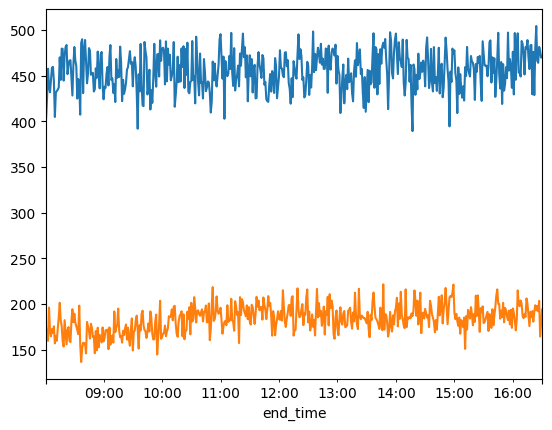

In [6]:
import matplotlib.pyplot as plt

min_df["WAP"].plot()
min_df["WBP"].plot()

<Figure size 2000x500 with 0 Axes>

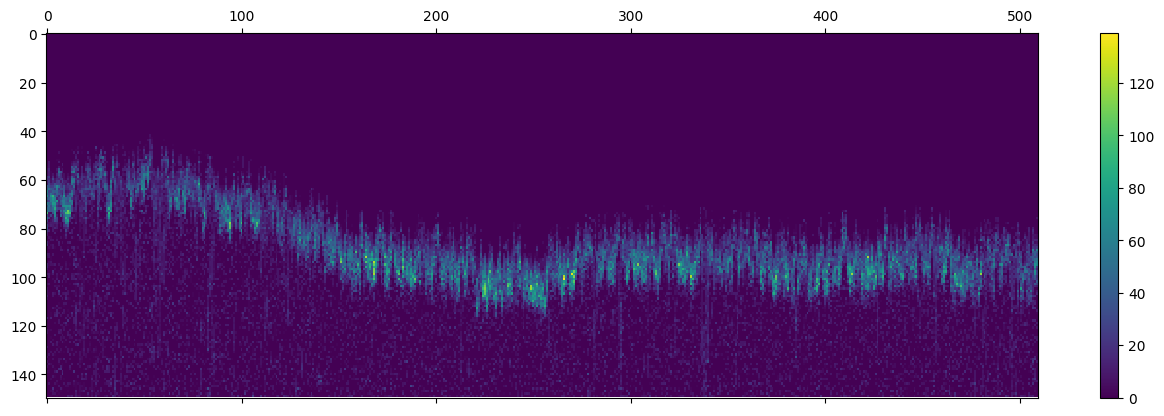

In [7]:
plt.figure(figsize=(20,5))
plt.matshow((cas_arr.T)[200:350], aspect = "auto")
plt.colorbar()

<Figure size 2000x500 with 0 Axes>

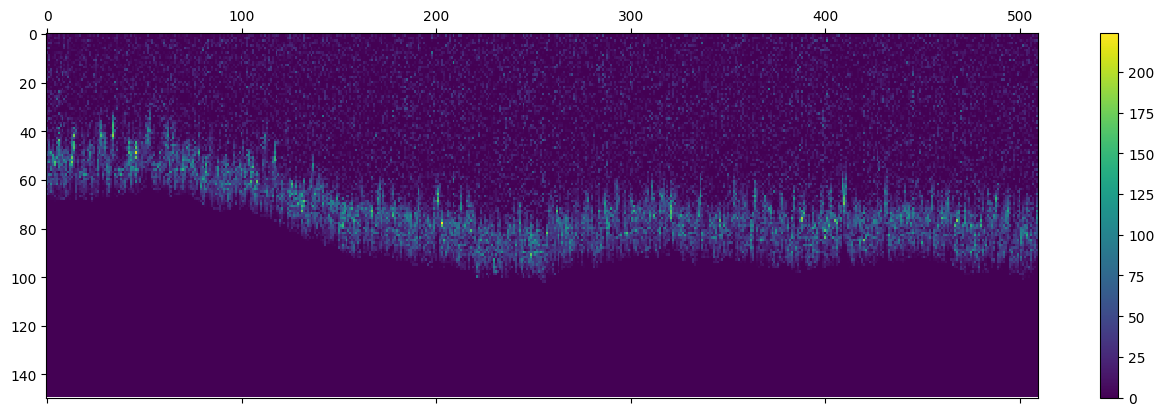

In [8]:
plt.figure(figsize=(20,5))
plt.matshow((cbs_arr.T)[200:350], aspect = "auto")
plt.colorbar()

array([[<Axes: title={'center': 'TCBS'}>,
        <Axes: title={'center': 'TCAS'}>],
       [<Axes: title={'center': 'WBP'}>, <Axes: title={'center': 'WAP'}>],
       [<Axes: title={'center': 'AWS'}>, <Axes: title={'center': 'WMP'}>]],
      dtype=object)

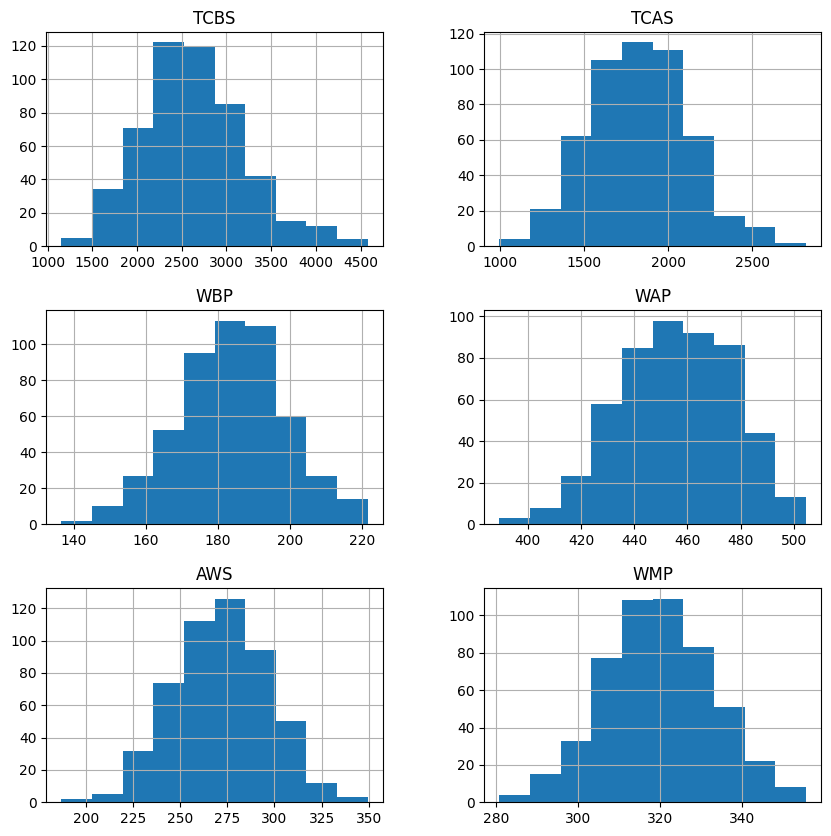

In [9]:
min_df.hist(figsize=(10,10))

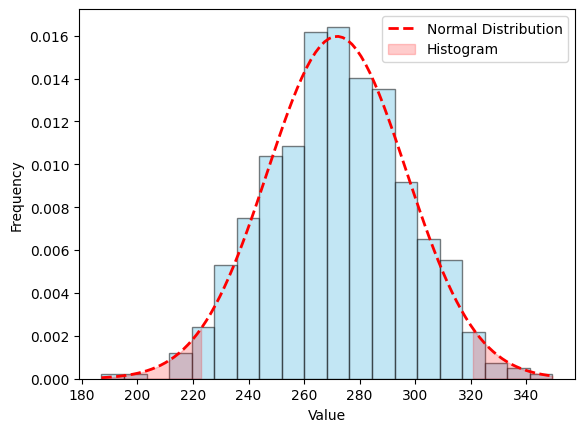

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming you have imported min_df and plt.hist(min_df["AWS"], bins=20) elsewhere

# Plot the histogram
plt.hist(min_df["AWS"], bins=20, density=True, alpha=0.5, color='skyblue', edgecolor='black')

# Calculate mean and standard deviation of the data
mean = min_df["AWS"].mean()
std_dev = min_df["AWS"].std()

# Generate data points for the normal distribution curve
x = np.linspace(min_df["AWS"].min(), min_df["AWS"].max(), 100)
y = norm.pdf(x, mean, std_dev)

# Plot the normal distribution curve
plt.plot(x, y, color='red', linestyle='--', linewidth=2)

# Calculate critical values for the lower and upper tails
lower_critical_value = norm.ppf(0.025, mean, std_dev)
upper_critical_value = norm.ppf(0.975, mean, std_dev)

# Shade the area representing values with a 5% probability on both tails
x_shade_lower = np.linspace(min_df["AWS"].min(), lower_critical_value, 100)
x_shade_upper = np.linspace(upper_critical_value, min_df["AWS"].max(), 100)
plt.fill_between(x_shade_lower, norm.pdf(x_shade_lower, mean, std_dev), color='red', alpha=0.2)
plt.fill_between(x_shade_upper, norm.pdf(x_shade_upper, mean, std_dev), color='red', alpha=0.2)

# Add legend and labels
plt.legend(['Normal Distribution', 'Histogram'])
plt.xlabel('Value')
plt.ylabel('Frequency')

# Show the plot
plt.show()


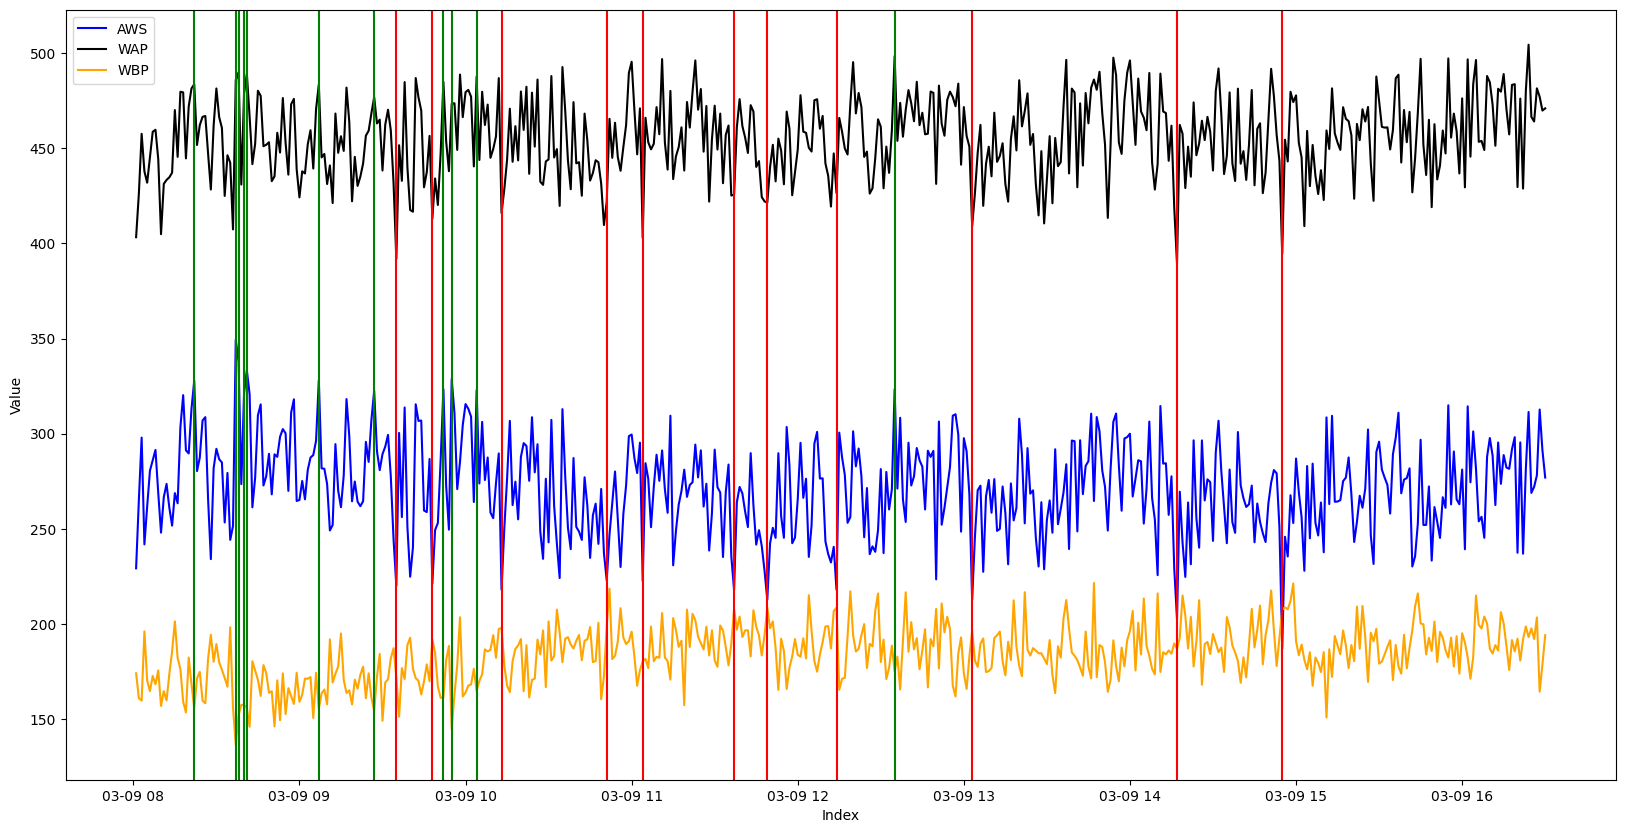

In [11]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

# Assuming you have imported min_df elsewhere

# Calculate mean and standard deviation of the data
mean = min_df["AWS"].mean()
std_dev = min_df["AWS"].std()

# Calculate critical values for the lower and upper tails
lower_critical_value = norm.ppf(0.025, mean, std_dev)
upper_critical_value = norm.ppf(0.975, mean, std_dev)

# Find the points within the tails
points_in_lower_tail = min_df["AWS"][min_df["AWS"] < lower_critical_value]
points_in_upper_tail = min_df["AWS"][min_df["AWS"] > upper_critical_value]

plt.figure(figsize=(20,10))
# Plot the line plot of min_df["AWS"]
plt.plot(min_df["AWS"], color='blue', label='AWS')
plt.plot(min_df["WAP"], color='black', label='WAP')
plt.plot(min_df["WBP"], color='orange', label='WBP')

# Highlight points in the lower tail
#plt.scatter(points_in_lower_tail.index, points_in_lower_tail, color='red', label='Lower Tail')

# Highlight points in the upper tail
#plt.scatter(points_in_upper_tail.index, points_in_upper_tail, color='green', label='Upper Tail')

for p in points_in_lower_tail.index:
    plt.axvline(p, color="red")

for p in points_in_upper_tail.index:
    plt.axvline(p, color="green")

# Add legend and labels
plt.legend()
plt.xlabel('Index')
plt.ylabel('Value')

# Show the plot
plt.show()


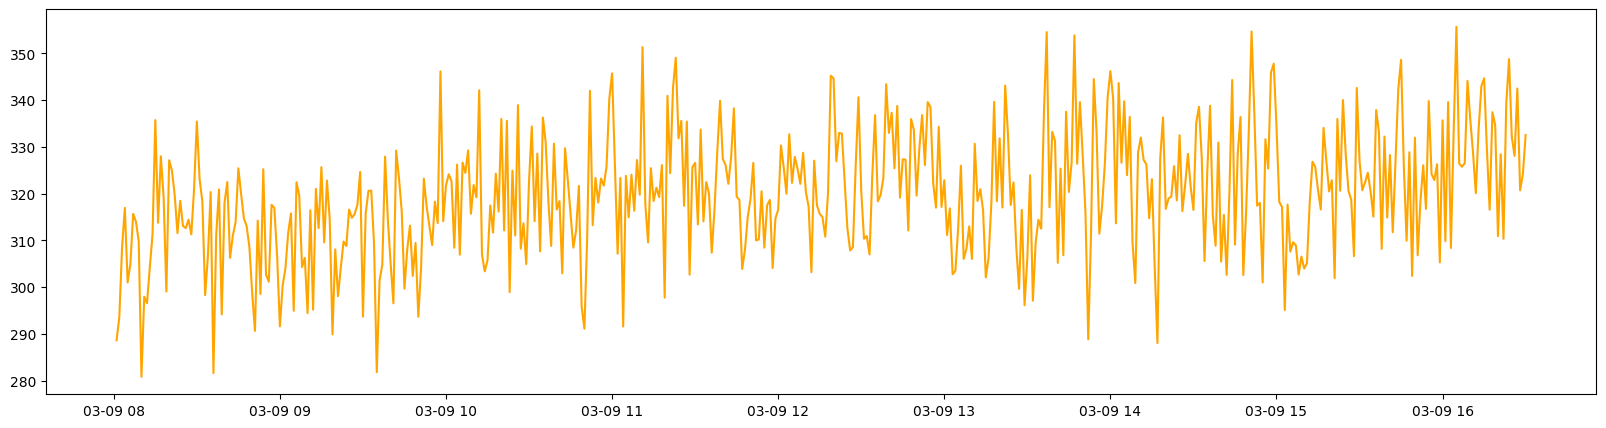

In [15]:
plt.figure(figsize=(20,5))
plt.plot(min_df["WMP"], color='orange', label='WBP')

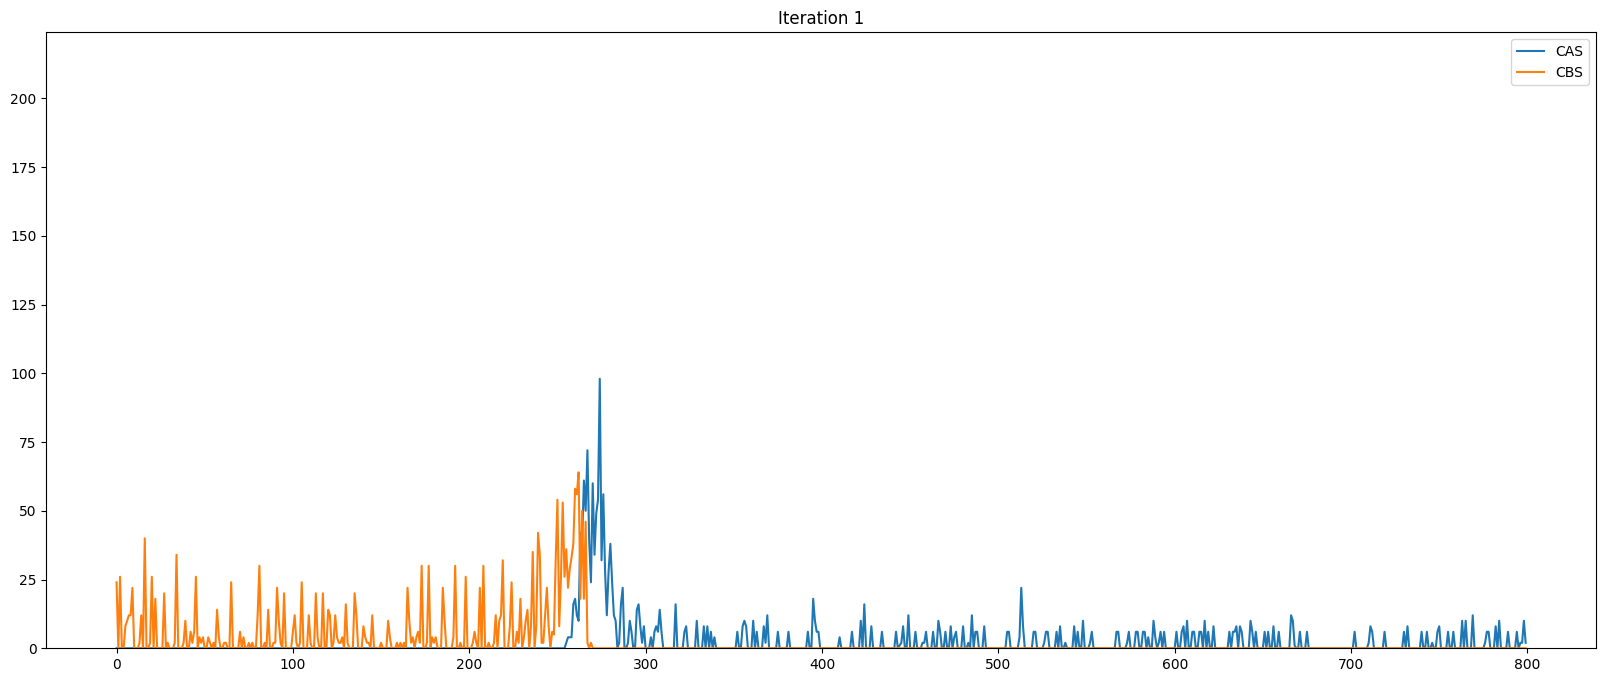

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Create the figure outside the update function
fig, ax = plt.subplots(figsize=(20, 8))

# Define a function to update the plot for each iteration
def update(frame):
  ax.clear()  # Clear the data in the existing axes
  ax.plot(cas_arr[frame], label='CAS')
  ax.plot(cbs_arr[frame], label='CBS')
  ax.legend()
  ax.set_ylim(0,max(np.max(cas_arr),np.max(cbs_arr)))
  ax.set_title(f'Iteration {frame+1}')  # Add iteration number to the title

# Create an animation
anim = FuncAnimation(fig, update, frames=len(cas_arr), interval=200)

# Save the animation as a GIF
anim.save('animation.gif', writer='pillow', fps=10)